# Store Sales Analysis and Forecasting

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from tqdm import tqdm
import gc



In [2]:
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('data/transactions.csv', parse_dates=['date'])

In [4]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
oil.info()
oil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
holidays.info()
holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [3]:
df_aim = pd.read_csv('data/test.csv', parse_dates=['date'])

In [4]:
df = pd.read_csv('data/train.csv', parse_dates=['date'])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [11]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [12]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [13]:
df.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [5]:
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [6]:
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [16]:
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
# Add store type to the data
df = df.merge(stores, on='store_nbr', how='left', suffixes=('', '_drop'))
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


In [8]:
# Add oil prices to the data
df = df.merge(oil, on='date', how='left', suffixes=('', '_drop'))
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,NaN


In [10]:
# Remove transferred holidays
holidays = holidays[holidays['transferred'] == False]

# Keep only valid holidays (not work days)
valid_types = ['Holiday', 'Additional', 'Bridge', 'Transfer']
holidays = holidays[holidays['holiday_type'].isin(valid_types)]

# Create three separate DataFrames for merging by locale
hol_national = holidays[holidays['locale'] == 'National'][['date', 'description']]
hol_national['is_holiday'] = True

hol_regional = holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'description']]
hol_regional['is_holiday'] = True

hol_local = holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'description']]
hol_local['is_holiday'] = True

In [11]:
# Start with national holidays
df = df.merge(hol_national, on='date', how='left')

# Then merge regional (match on state)
df = df.merge(
    hol_regional, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_regional')
)

# Then merge local (match on city)
df = df.merge(
    hol_local, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_local')
)

df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,description,is_holiday,locale_name,description_regional,is_holiday_regional,locale_name_local,description_local,is_holiday_local
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Create a single is_holiday flag: True if any of the merges matched
df['is_holiday'] = (
    df['is_holiday'].fillna(False) |
    df['is_holiday_regional'].fillna(False) |
    df['is_holiday_local'].fillna(False)
)

# Drop temporary columns
df.drop(columns=['description', 'description_regional', 'description_local',
                           'is_holiday_regional', 'is_holiday_local',
                           'locale_name', 'locale_name_local'], errors='ignore', inplace=True)


In [12]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14,False
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97,False
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12,False
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,NaN,False


In [15]:
# Check for missing values
df.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
dcoilwtico     928686
is_holiday          0
dtype: int64

In [13]:
# Sort by date
df = df.sort_values(by='date')


In [14]:
# Merge with df on date and store
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')


In [15]:
df.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True,NaN
1,1003,2013-01-01,37,GROCERY II,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
2,1002,2013-01-01,37,GROCERY I,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
3,1001,2013-01-01,37,FROZEN FOODS,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
4,1000,2013-01-01,37,EGGS,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
5,999,2013-01-01,37,DELI,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
6,998,2013-01-01,37,DAIRY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
7,997,2013-01-01,37,CLEANING,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
8,996,2013-01-01,37,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN
9,995,2013-01-01,37,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,NaN,True,NaN


In [18]:
df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
dcoilwtico      928686
is_holiday           0
transactions    245982
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002934 entries, 0 to 3002933
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   store_type    object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  is_holiday    bool          
 12  transactions  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 300.7+ MB


In [15]:
# Fill missing values
# Interpolate missing 'dcoilwtico' based on time
df = df.set_index('date')
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='time')

# Fill any remaining NaNs in 'dcoilwtico' (e.g., start or end)
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='bfill').fillna(method='ffill')

# Reset index to bring 'date' back as a column
df = df.reset_index()

# Fill missing values in 'transactions' with 0
df['transactions'] = df['transactions'].fillna(0)

df.isnull().sum()

date            0
id              0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
dcoilwtico      0
is_holiday      0
transactions    0
dtype: int64

In [16]:
# Time-based features
df['year'] = df['date'].dt.year              # Extracts year
df['month'] = df['date'].dt.month            # Extracts month (1–12)
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 for Sat/Sun
df['day_of_month'] = df['date'].dt.day        # Day of the month (1–31)
df['week_of_year'] = df['date'].dt.isocalendar().week # Week of the year (1–53)

In [21]:
df.head(10)

,date,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday,transactions,year,month,day_of_week,is_weekend,day_of_month,week_of_year
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,True,0.0,2013,1,1,0,1,1
1,2013-01-01,1003,37,GROCERY II,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
2,2013-01-01,1002,37,GROCERY I,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
3,2013-01-01,1001,37,FROZEN FOODS,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
4,2013-01-01,1000,37,EGGS,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
5,2013-01-01,999,37,DELI,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
6,2013-01-01,998,37,DAIRY,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
7,2013-01-01,997,37,CLEANING,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
8,2013-01-01,996,37,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1
9,2013-01-01,995,37,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,93.14,True,0.0,2013,1,1,0,1,1


## Exploratory Data Analysis (EDA)

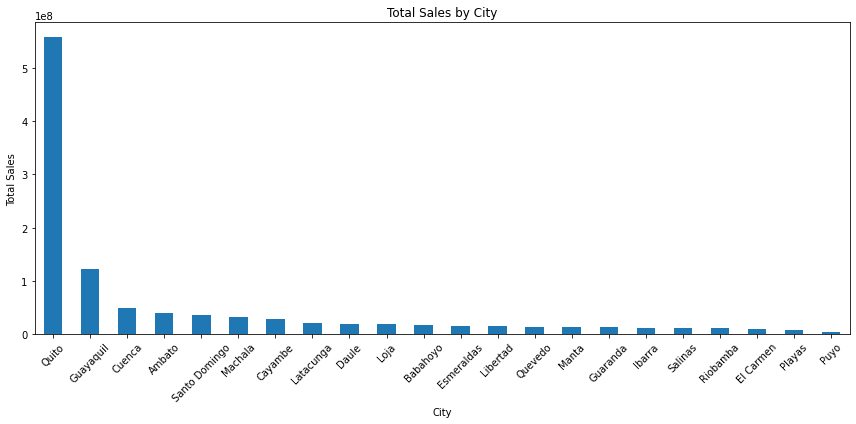

In [ ]:
# Total sales by city
sales_by_city = df.groupby('city')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_city.plot(kind='bar')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

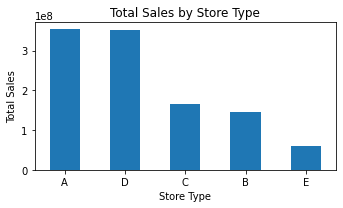

In [30]:
# Total sales by store type
sales_by_type = df.groupby('store_type')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sales_by_type.plot(kind='bar')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


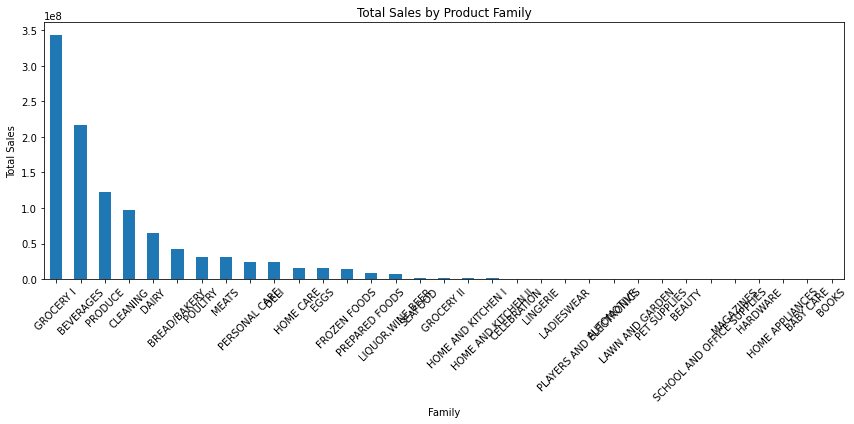

In [31]:
# Total sales by product family
sales_by_family = df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_family.plot(kind='bar')
plt.title('Total Sales by Product Family')
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


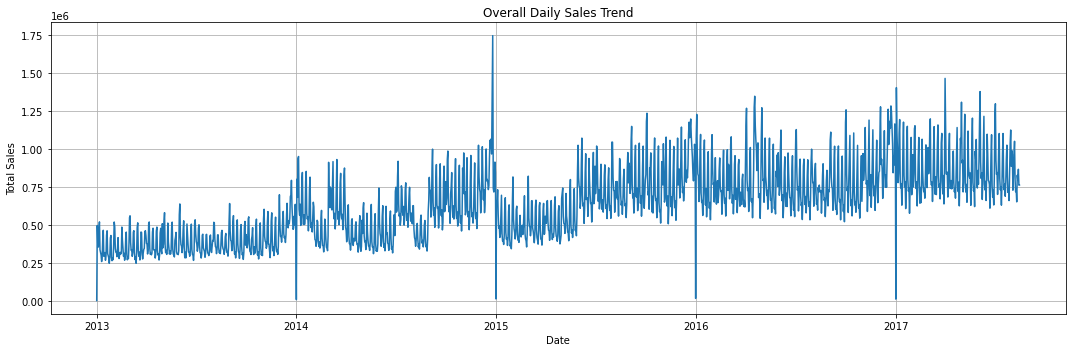

In [32]:
# Aggregate daily total sales across all stores and families
daily_sales = df.groupby('date')['sales'].sum()

# Plot the overall sales trend
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

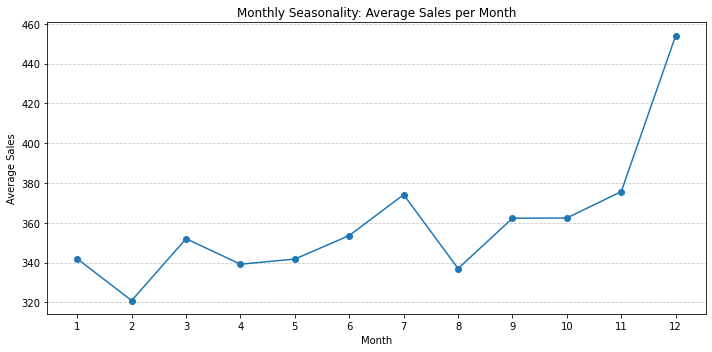

In [33]:
# Group by month and calculate average sales
monthly_avg_sales = df.groupby('month')['sales'].mean()

# Plot
plt.figure(figsize=(10, 5))
monthly_avg_sales.plot(kind='line', marker='o')
plt.title('Monthly Seasonality: Average Sales per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

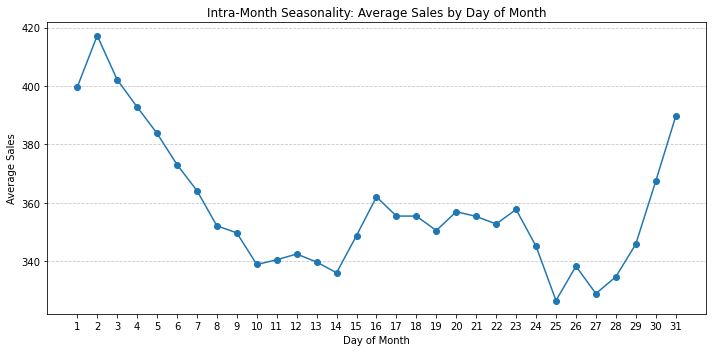

In [34]:
# Group by day of month and compute average sales
avg_sales_by_day = df.groupby('day_of_month')['sales'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_sales_by_day.plot(kind='line', marker='o')
plt.title('Intra-Month Seasonality: Average Sales by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

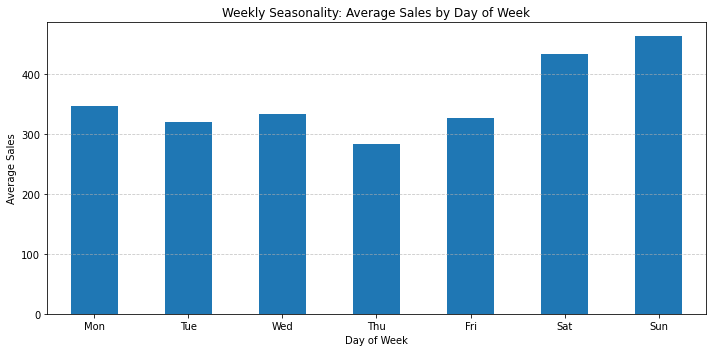

In [35]:
# Average Sales by Day of Week
plt.figure(figsize=(10, 5))
avg_sales_by_dow = df.groupby('day_of_week')['sales'].mean()
avg_sales_by_dow.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_sales_by_dow.plot(kind='bar')
plt.title('Weekly Seasonality: Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


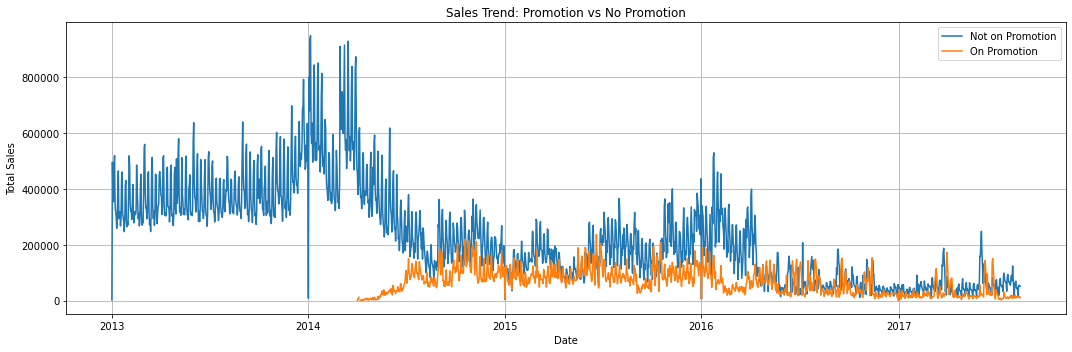

In [36]:
# Group by date and promotion status, then calculate total sales
promo_impact = df.groupby(['date', 'onpromotion'])['sales'].sum().unstack()

# Plot sales for promoted vs. non-promoted items
plt.figure(figsize=(15, 5))
plt.plot(promo_impact.index, promo_impact[0], label='Not on Promotion')
plt.plot(promo_impact.index, promo_impact[1], label='On Promotion')
plt.title('Sales Trend: Promotion vs No Promotion')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

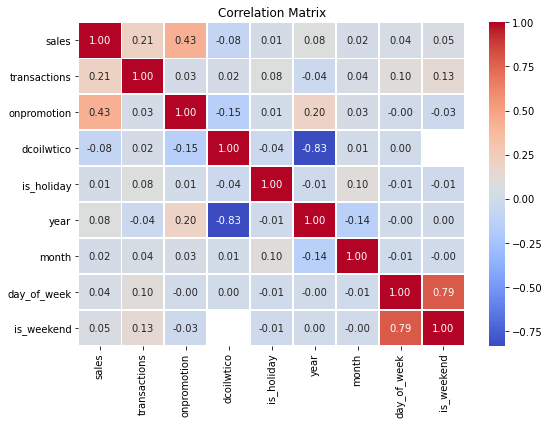

In [37]:
# Correlation Analysis
corr_cols = ['sales', 'transactions', 'onpromotion', 'dcoilwtico',
             'is_holiday', 'year', 'month', 'day_of_week', 'is_weekend']

# Compute correlation matrix
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

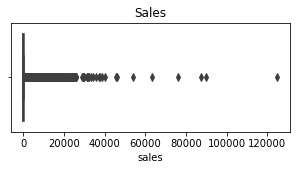

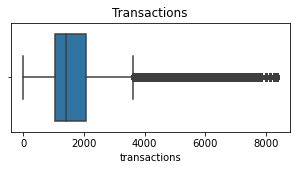

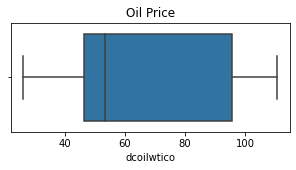

In [38]:
# Check for outliers
plt.figure(figsize=(5, 2))
sns.boxplot(x=df['sales'])
plt.title('Sales')
plt.show()

plt.figure(figsize=(5, 2))
sns.boxplot(x=df['transactions'])
plt.title('Transactions')
plt.show()

plt.figure(figsize=(5, 2))
sns.boxplot(x=df['dcoilwtico'].dropna())
plt.title('Oil Price')
plt.show()


## Feature Engineering

In [ ]:
# Lag features for sales and promotion status
df['sales_lag_1'] = df.groupby(['store_nbr', 'family'])['sales'].shift(1) # Previous day's sales
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7) # Sales from the same day last week
df['onpromotion_lag_1'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1) # Previous day's promotion status

# Rolling mean of sales for the last 7 days
df['rolling_mean_7'] = (
    df.groupby(['store_nbr', 'family'])['sales']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())
) 

# Rolling standard deviation of sales for the last 7 days
df['rolling_std_7'] = (
    df.groupby(['store_nbr', 'family'])['sales']
      .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std())
)

# Create a flag for days around holidays
df['is_day_before_holiday'] = df['is_holiday'].shift(-1).fillna(0).astype(int)
df['is_day_after_holiday'] = df['is_holiday'].shift(1).fillna(0).astype(int)


In [26]:
df.head()

,date,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,is_weekend,day_of_month,week_of_year,sales_lag_1,sales_lag_7,onpromotion_lag_1,rolling_mean_7,rolling_std_7,is_day_before_holiday,is_day_after_holiday
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,1,1,NaN,NaN,NaN,NaN,NaN,1,0
1,2013-01-01,1003,37,GROCERY II,0.0,0,Cuenca,Azuay,D,2,...,0,1,1,NaN,NaN,NaN,NaN,NaN,1,1
2,2013-01-01,1002,37,GROCERY I,0.0,0,Cuenca,Azuay,D,2,...,0,1,1,NaN,NaN,NaN,NaN,NaN,1,1
3,2013-01-01,1001,37,FROZEN FOODS,0.0,0,Cuenca,Azuay,D,2,...,0,1,1,NaN,NaN,NaN,NaN,NaN,1,1
4,2013-01-01,1000,37,EGGS,0.0,0,Cuenca,Azuay,D,2,...,0,1,1,NaN,NaN,NaN,NaN,NaN,1,1


In [22]:
df.isnull().sum()

date                         0
id                           0
store_nbr                    0
family                       0
sales                        0
onpromotion                  0
city                         0
state                        0
store_type                   0
cluster                      0
dcoilwtico                   0
is_holiday                   0
transactions                 0
year                         0
month                        0
day_of_week                  0
is_weekend                   0
day_of_month                 0
week_of_year                 0
sales_lag_1               1782
sales_lag_7              12474
onpromotion_lag_1         1782
rolling_mean_7            1782
rolling_std_7             3564
is_day_before_holiday        0
is_day_after_holiday         0
dtype: int64

In [18]:
# Drop rows with NaN values in lag features
lag_cols = [
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7'
]

# Drop rows with any NaNs in those features
df = df.dropna(subset=lag_cols)

In [23]:
df.isnull().sum()

date                     0
id                       0
store_nbr                0
family                   0
sales                    0
onpromotion              0
city                     0
state                    0
store_type               0
cluster                  0
dcoilwtico               0
is_holiday               0
transactions             0
year                     0
month                    0
day_of_week              0
is_weekend               0
day_of_month             0
week_of_year             0
sales_lag_1              0
sales_lag_7              0
onpromotion_lag_1        0
rolling_mean_7           0
rolling_std_7            0
is_day_before_holiday    0
is_day_after_holiday     0
dtype: int64

## Train-Test Split


In [ ]:
cutoff_date = '2017-06-01'
train = df[df['date'] < cutoff_date]
test = df[df['date'] >= cutoff_date]


## Baseline Model

In [ ]:
# Random Forest
target = 'sales'
features = ['is_holiday', 'day_of_week', 'onpromotion', 'dcoilwtico', 'transactions']

X_train_baseline = train[features]
y_train_baseline = train[target]

X_test_baseline = test[features]
y_test_baseline = test[target]

# Define the model
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model
baseline_model.fit(X_train_baseline, y_train_baseline)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_baseline)

# Evaluate the baseline model
rmse_baseline = mean_squared_error(y_test_baseline, y_pred_baseline, squared=False)
mae_baseline = mean_absolute_error(y_test_baseline, y_pred_baseline)
r2_baseline = r2_score(y_test_baseline, y_pred_baseline)

print(f"Random Forest (Baseline Model):")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"MAE: {mae_baseline:.2f}")
print(f"R²: {r2_baseline:.3f}")

Baseline Model - MSE: 1182808.52, MAE: 506.12, R^2: 0.33


## Advanced Models

In [25]:
# Define categorical and numerical features
categorical_features = ['store_nbr', 'family', 'city', 'state', 'store_type']

numerical_features = [
    'onpromotion', 'cluster', 'dcoilwtico', 'week_of_year',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'is_day_before_holiday', 'is_day_after_holiday',
]

all_features = categorical_features + numerical_features

In [26]:
# Random Forest with Hyperparameter Tuning
X_train = train[all_features]
y_train = train['sales']

X_test = test[all_features]
y_test = test['sales']

# OneHotEncoder for categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# Build the pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=30, max_depth=6, n_jobs=-1, random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"RMSE Random Forest: {rmse:.2f}")
print(f"MAE Random Forest:  {mae:.2f}")
print(f"R² Random Forest:   {r2:.3f}")


RMSE Random Forest: 297.92
MAE Random Forest:  84.91
R² Random Forest:   0.950


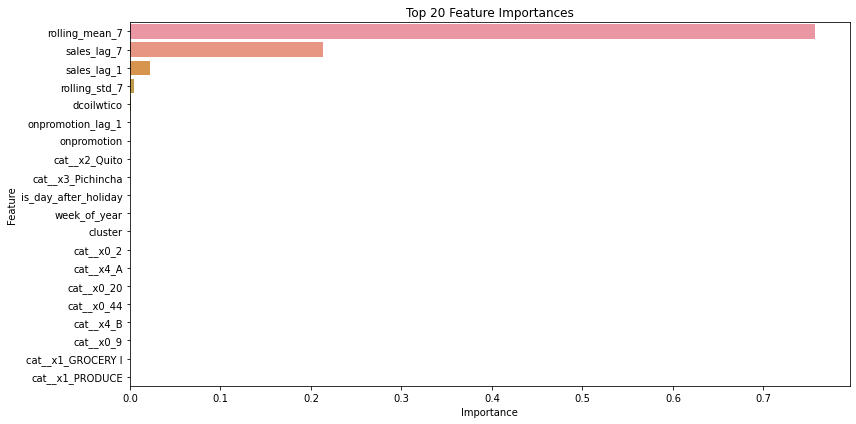

In [ ]:
# Feature Importance Random Forest
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names()

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)   

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [19]:
# XGBoost Hyperparameter Tuning
categorical_ohe = ['family', 'store_type']         # OneHotEncode only these
numerical_features = [
    'onpromotion', 'cluster', 'dcoilwtico', 'week_of_year',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'is_day_before_holiday', 'is_day_after_holiday',
]

all_features = categorical_ohe + numerical_features

X_train_xgb = train[all_features]
y_train_xgb = train['sales']

X_test_xgb = test[all_features]
y_test_xgb = test['sales']

# Define the preprocessor for the pipeline
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True), categorical_ohe),
        ('pass', 'passthrough', numerical_features)
    ]
)

# Build the pipeline with XGBoost
model_xgb = Pipeline(steps=[
    ('preprocessor_xgb', preprocessor_xgb),
    ('regressor_xgb', XGBRegressor(
        n_estimators=30,
        max_depth=6,
        learning_rate=0.1,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    ))
])

# Fit the model
model_xgb.fit(X_train_xgb, y_train_xgb)

# Make predictions
preds_xgb = model_xgb.predict(X_test_xgb)

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, preds_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, preds_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE:  {mae_xgb:.2f}")
print(f"XGBoost R²:   {r2_score(y_test_xgb, preds_xgb):.3f}")

XGBoost RMSE: 302.23
XGBoost MAE:  84.62
XGBoost R²:   0.949


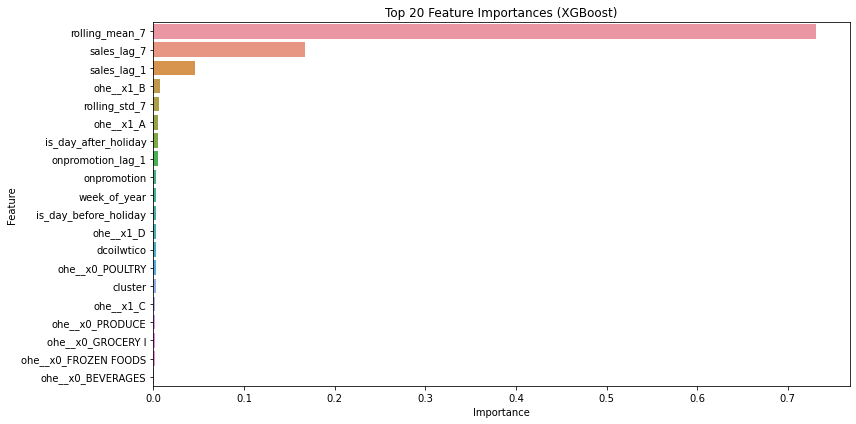

In [29]:
# Feature Importance for XGBoost
importances_xgb = model_xgb.named_steps['regressor_xgb'].feature_importances_
feature_names_xgb = model_xgb.named_steps['preprocessor_xgb'].get_feature_names()

# Create a DataFrame for feature importances
feature_importances_xgb = pd.DataFrame({
    'feature': feature_names_xgb,
    'importance': importances_xgb
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_xgb.head(20))
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [20]:
# LightGBM Hyperparameter Tuning

# Define categorical and numerical features for LightGBM
categorical_features_lgb = ['family', 'store_type']

numerical_features_lgb = [
    'onpromotion', 'cluster', 'dcoilwtico', 'week_of_year',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'is_day_before_holiday', 'is_day_after_holiday'
]

all_features_lgb = categorical_features_lgb + numerical_features_lgb

# Convert categorical features to 'category' dtype
for col in categorical_features_lgb:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')


# Prepare the training and testing data 
X_train_lgb = train[all_features_lgb]
y_train_lgb = train['sales']

X_test_lgb = test[all_features_lgb]
y_test_lgb = test['sales']

# Define the LightGBM model
model_lgb = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Fit the LightGBM model
model_lgb.fit(
    X_train_lgb, y_train_lgb,
    eval_set=[(X_test_lgb, y_test_lgb)],
    callbacks=[early_stopping(stopping_rounds=10)]
)

# Evaluate Model
preds_lgb = model_lgb.predict(X_test_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test_lgb, preds_lgb))
mae_lgb = mean_absolute_error(y_test_lgb, preds_lgb)
r2_lgb = r2_score(y_test_lgb, preds_lgb)

print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"LightGBM MAE:  {mae_lgb:.2f}")
print(f"LightGBM R²:   {r2_lgb:.3f}")



<ipython-input-20-e7f797818f8a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].astype('category')
<ipython-input-20-e7f797818f8a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = test[col].astype('category')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 2855028, number of used features: 13
[LightGBM] [Info] Start training from score 352.683721
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 80116
LightGBM RMSE: 283.05
LightGBM MAE:  76.28
LightGBM R²:   0.955


In [44]:
# LightGBM TimeSeriesSplit Cross-Validation
# Use only pre-cutoff data for cross-validation
cutoff_date = '2017-06-01'
train_cv = df[df['date'] < cutoff_date].copy()

# Define features
categorical_features_lgb = ['family', 'store_type']
numerical_features_lgb = [
    'onpromotion', 'cluster', 'dcoilwtico', 'week_of_year',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'is_day_before_holiday', 'is_day_after_holiday'
]
all_features_lgb = categorical_features_lgb + numerical_features_lgb

# Cast categorical columns
for col in categorical_features_lgb:
    train_cv[col] = train_cv[col].astype('category')

X_cv = train_cv[all_features_lgb]
y_cv = train_cv['sales']

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores, mae_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_cv)):
    X_train_fold, X_val_fold = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
    y_train_fold, y_val_fold = y_cv.iloc[train_idx], y_cv.iloc[val_idx]

    model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )

    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        callbacks=[lgb.early_stopping(stopping_rounds=10)],
        categorical_feature=categorical_features_lgb
    )

    preds = model.predict(X_val_fold)

    rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, preds)))
    mae_scores.append(mean_absolute_error(y_val_fold, preds))
    r2_scores.append(r2_score(y_val_fold, preds))

    print(f"Fold {fold+1}: RMSE={rmse_scores[-1]:.2f}, MAE={mae_scores[-1]:.2f}, R²={r2_scores[-1]:.3f}")

print("\n Cross-Validation Results (LightGBM + TimeSeriesSplit):")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Avg MAE:  {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Avg R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 475838, number of used features: 11
[LightGBM] [Info] Start training from score 206.743088
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 71594.4
Fold 1: RMSE=267.57, MAE=58.40, R²=0.907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1471
[LightGBM] [Info] Number of data points in the train set: 951676, number of used features: 13
[LightGBM] [Info] Start training from score 238.403038
Training until val

In [24]:
# LightGBM + Grid Search
categorical_features_lgb = ['family', 'store_type']
numerical_features_lgb = [
    'onpromotion', 'cluster', 'dcoilwtico', 'week_of_year',
    'sales_lag_1', 'sales_lag_7', 'onpromotion_lag_1',
    'rolling_mean_7', 'rolling_std_7',
    'is_day_before_holiday', 'is_day_after_holiday'
]
all_features_lgb = categorical_features_lgb + numerical_features_lgb

cutoff_date = '2017-06-01'
train_final = df[df['date'] < cutoff_date].copy()
test_final = df[df['date'] >= cutoff_date].copy()

# Convert categoricals to 'category'
for col in categorical_features_lgb:
    train_final[col] = train_final[col].astype('category')
    test_final[col] = test_final[col].astype('category')

X_train_final = train_final[all_features_lgb]
y_train_final = train_final['sales']
X_test_final = test_final[all_features_lgb]
y_test_final = test_final['sales']

# Define RMSE Scorer
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# Define Parameter Grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 64]
}

# TimeSeriesSplit CV
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
model = LGBMRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

print("🔍 Running GridSearchCV...")
grid_search.fit(X_train_final, y_train_final)

# Best Params & Score
best_params = grid_search.best_params_
print("\n Best Parameters:", best_params)
print(f" Best Cross-Validated RMSE: {-grid_search.best_score_:.2f}")

# Retrain Final Model on Full Training Set
best_model_lgb = LGBMRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_model_lgb.fit(
    X_train_final, y_train_final,
    categorical_feature=categorical_features_lgb
)

# Evaluate on Hold-Out Test Set
preds_final = best_model_lgb.predict(X_test_final)

rmse_final = np.sqrt(mean_squared_error(y_test_final, preds_final))
mae_final = mean_absolute_error(y_test_final, preds_final)
r2_final = r2_score(y_test_final, preds_final)

print("\n Final Evaluation on Hold-Out Test Set:")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE:  {mae_final:.2f}")
print(f"R²:   {r2_final:.3f}")
print(f"Best Parameters: {best_params}")

🔍 Running GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 2855028, number of used features: 13
[LightGBM] [Info] Start training from score 352.683721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

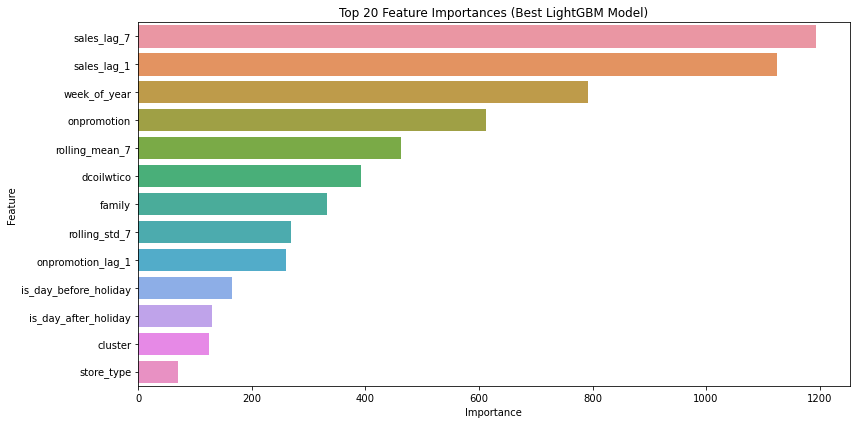

In [53]:
# Feature Importance for Best Model
importances_final = best_model_lgb.feature_importances_
feature_names_final = X_train_final.columns

# Create a DataFrame for feature importances
importance_df_final = pd.DataFrame({
    'feature': feature_names_final,
    'importance': importances_final
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df_final.head(20))
plt.title('Top 20 Feature Importances (Best LightGBM Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()